# Introduction

## Brief Description of the Competition and Its Goals

In this competition, we aim to predict sales for thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building our models.

Specifically, we'll build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores. This will help ensure retailers have just enough of the right products at the right time, decreasing food waste related to overstocking and improving customer satisfaction.

## Explanation of the Evaluation Metric (RMSLE)

The evaluation metric for this competition is Root Mean Squared Logarithmic Error (RMSLE). The RMSLE is calculated as:

$$
RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log(1 + \hat{y}_i) - \log(1 + y_i))^2}
$$

where:
- \( n \) is the total number of instances,
- \( \hat{y}_i \) is the predicted value of the target for instance \( i \),
- \( y_i \) is the actual value of the target for instance \( i \), and
- \( \log \) is the natural logarithm.

This metric is useful for this competition because it penalizes underestimates more than overestimates, which is important in a retail context where underestimating sales can lead to stockouts and lost revenue.

# Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Load Dataset
Load the dataset

In [2]:
# Load the training and test datasets
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# Load the supplementary datasets
stores_df = pd.read_csv('data/stores.csv')
oil_df = pd.read_csv('data/oil.csv')
holidays_events_df = pd.read_csv('data/holidays_events.csv')
transactions_df = pd.read_csv('data/transactions.csv')

In [3]:
# Display the first few rows of each dataset
print("Training Data:")
print(train_df.head())
print("Size of training data:", train_df.shape)

print("\nTest Data:")
print(test_df.head())
print("Size of test data:", test_df.shape)

print("\nStores Data:")
print(stores_df.head())
print("Size of stores data:", stores_df.shape)

print("\nOil Data:")
print(oil_df.head())
print("Size of oil data:", oil_df.shape)

print("\nHolidays and Events Data:")
print(holidays_events_df.head())
print("Size of holidays and events data:", holidays_events_df.shape)

print("\nTransactions Data:")
print(transactions_df.head())
print("Size of transactions data:", transactions_df.shape)

Training Data:
   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0
Size of training data: (3000888, 6)

Test Data:
        id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0
Size of test data: (28512, 5)

Stores Data:
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Qui

# Data Preprocessing

## Handle Missing Values

In [4]:
# Check for missing values in the training dataset
print("Missing values in training data:")
print(train_df.isnull().sum())

# Check for missing values in the test dataset
print("\nMissing values in test data:")
print(test_df.isnull().sum())

# Check for missing values in the stores dataset
print("\nMissing values in stores data:")
print(stores_df.isnull().sum())

# Check for missing values in the oil dataset
print("\nMissing values in oil data:")
print(oil_df.isnull().sum())

# Check for missing values in the holidays and events dataset
print("\nMissing values in holidays and events data:")
print(holidays_events_df.isnull().sum())

print("\nMissing values in transactions data:")
print(transactions_df.isnull().sum())

Missing values in training data:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Missing values in test data:
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

Missing values in stores data:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

Missing values in oil data:
date           0
dcoilwtico    43
dtype: int64

Missing values in holidays and events data:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Missing values in transactions data:
date            0
store_nbr       0
transactions    0
dtype: int64


We only have 43 missing values in the oil data.

Given that the oil dataset has 1218 rows and only 43 missing values, forward fill (propagating the last observed value forward) is a convenient technique. This method is particularly useful for time series data, as it maintains the continuity of the data and is less likely to introduce bias compared to mean or median imputation.

In [5]:
# Forward Fill: Replace missing values with the last observed value
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].ffill()

# Backward Fill: Replace any remaining missing values with the next observed value
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].bfill()

# Verify that there are no missing values left
print("Missing values in oil data after forward and backward fill:")
print(oil_df.isnull().sum())

Missing values in oil data after forward and backward fill:
date          0
dcoilwtico    0
dtype: int64


# Convert Data Types

In [6]:
# Verify the data types
print("Data types in training data:")
print(train_df.dtypes)

print("\nData types in test data:")
print(test_df.dtypes)

print("\nData types in oil data:")
print(oil_df.dtypes)

print("\nData types in holidays and events data:")
print(holidays_events_df.dtypes)

print("\nData types in transactions data:")
print(transactions_df.dtypes)

Data types in training data:
id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

Data types in test data:
id              int64
date           object
store_nbr       int64
family         object
onpromotion     int64
dtype: object

Data types in oil data:
date           object
dcoilwtico    float64
dtype: object

Data types in holidays and events data:
date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object

Data types in transactions data:
date            object
store_nbr        int64
transactions     int64
dtype: object


In [7]:
# Convert date columns to datetime
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
oil_df['date'] = pd.to_datetime(oil_df['date'])
holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

# Verify the data types
print("Data types in training data:")
print(train_df.dtypes)

print("\nData types in test data:")
print(test_df.dtypes)

print("\nData types in oil data:")
print(oil_df.dtypes)

print("\nData types in holidays and events data:")
print(holidays_events_df.dtypes)

print("\nData types in transactions data:")
print(transactions_df.dtypes)

Data types in training data:
id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

Data types in test data:
id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
onpromotion             int64
dtype: object

Data types in oil data:
date          datetime64[ns]
dcoilwtico           float64
dtype: object

Data types in holidays and events data:
date           datetime64[ns]
type                   object
locale                 object
locale_name            object
description            object
transferred              bool
dtype: object

Data types in transactions data:
date            datetime64[ns]
store_nbr                int64
transactions             int64
dtype: object


# Merge Datasets

In [8]:
# Merge the training data with the supplementary datasets

# Merge with stores data
train_df = train_df.merge(stores_df, on='store_nbr', how='left')
test_df = test_df.merge(stores_df, on='store_nbr', how='left')

# Merge with oil data
train_df = train_df.merge(oil_df, on='date', how='left')
test_df = test_df.merge(oil_df, on='date', how='left')

# Merge with holidays and events data
train_df = train_df.merge(holidays_events_df, on='date', how='left')
test_df = test_df.merge(holidays_events_df, on='date', how='left')

# Merge with transactions data
train_df = train_df.merge(transactions_df, on=['date', 'store_nbr'], how='left')
test_df = test_df.merge(transactions_df, on=['date', 'store_nbr'], how='left')

In [9]:
# Display the first few rows of the merged training data
print("Merged Training Data:")
print(train_df.head())
print("Size of merged training data:", train_df.shape)

# Display the first few rows of the merged test data
print("Merged Test Data:")
print(test_df.head())
print("Size of merged test data:", test_df.shape)

Merged Training Data:
   id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4   4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  type_x  cluster  dcoilwtico   type_y    locale locale_name  \
0      D       13       93.14  Holiday  National     Ecuador   
1      D       13       93.14  Holiday  National     Ecuador   
2      D       13       93.14  Holiday  National     Ecuador   
3      D       13       93.14  Holiday  National     Ecuador   
4      D       13       93.14  Holiday  National     Ecuador   

          description transferred  transactions  
0  Primer dia del ano       False           NaN  
1  Pri

# Feature Engineering

The next step is to perform feature engineering to create new features that can help improve the model's performance. Here are some feature engineering steps you can take:

- Extract Date Components: Extract year, month, day, and day of the week from the date column.
- Lag Features: Create lag features for sales to capture trends and seasonality.
- Rolling Statistics: Create rolling mean, median, and standard deviation features for sales.
- Promotion Features: Create features indicating whether a product was on promotion.
- Holiday Features: Create features indicating whether a date is a holiday or an event.

Let's start with extracting date components:

In [10]:
# Extract date components
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['day_of_week'] = train_df['date'].dt.dayofweek

test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['day_of_week'] = test_df['date'].dt.dayofweek

# Display the first few rows of the training data with new features
print("Training Data with Date Components:")
print(train_df.head())

# Display the first few rows of the test data with new features
print("Test Data with Date Components:")
print(test_df.head())

Training Data with Date Components:
   id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4   4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  type_x  cluster  ...   type_y    locale locale_name         description  \
0      D       13  ...  Holiday  National     Ecuador  Primer dia del ano   
1      D       13  ...  Holiday  National     Ecuador  Primer dia del ano   
2      D       13  ...  Holiday  National     Ecuador  Primer dia del ano   
3      D       13  ...  Holiday  National     Ecuador  Primer dia del ano   
4      D       13  ...  Holiday  National     Ecuador  Primer dia del ano   

  transferred 

Next, let's create lag features for sales:

In [11]:
# Create lag features for sales
train_df['lag_1'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(1)
train_df['lag_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(7)
train_df['lag_30'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(30)

# Display the first few rows of the training data with lag features
print("Training Data with Lag Features:")
print(train_df.head())

Training Data with Lag Features:
   id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4   4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  type_x  cluster  ...         description transferred transactions  year  \
0      D       13  ...  Primer dia del ano       False          NaN  2013   
1      D       13  ...  Primer dia del ano       False          NaN  2013   
2      D       13  ...  Primer dia del ano       False          NaN  2013   
3      D       13  ...  Primer dia del ano       False          NaN  2013   
4      D       13  ...  Primer dia del ano       False          NaN  2013   

  month day  day_

Now, let's create rolling statistics for sales:

In [12]:
# Create rolling mean, median, and standard deviation features for sales
train_df['rolling_mean_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].rolling(7).mean().reset_index(level=[0,1], drop=True)
train_df['rolling_median_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].rolling(7).median().reset_index(level=[0,1], drop=True)
train_df['rolling_std_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].rolling(7).std().reset_index(level=[0,1], drop=True)

# Display the first few rows of the training data with rolling statistics
print("Training Data with Rolling Statistics:")
print(train_df.head())

Training Data with Rolling Statistics:
   id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4   4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  type_x  cluster  ...  year month day day_of_week lag_1 lag_7  lag_30  \
0      D       13  ...  2013     1   1           1   NaN   NaN     NaN   
1      D       13  ...  2013     1   1           1   NaN   NaN     NaN   
2      D       13  ...  2013     1   1           1   NaN   NaN     NaN   
3      D       13  ...  2013     1   1           1   NaN   NaN     NaN   
4      D       13  ...  2013     1   1           1   NaN   NaN     NaN   

   rolling_mean_7  rolling_me

Finally, let's create promotion and holiday features:

In [13]:
# Create promotion features
train_df['is_promoted'] = train_df['onpromotion'] > 0
test_df['is_promoted'] = test_df['onpromotion'] > 0

# Create holiday features
train_df['is_holiday'] = train_df['type_y'].notnull()
test_df['is_holiday'] = test_df['type_y'].notnull()

# Display the first few rows of the training data with promotion and holiday features
print("Training Data with Promotion and Holiday Features:")
print(train_df.head())

# Display the first few rows of the test data with promotion and holiday features
print("Test Data with Promotion and Holiday Features:")
print(test_df.head())

Training Data with Promotion and Holiday Features:
   id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4   4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  type_x  cluster  ...  day day_of_week lag_1 lag_7 lag_30 rolling_mean_7  \
0      D       13  ...    1           1   NaN   NaN    NaN            NaN   
1      D       13  ...    1           1   NaN   NaN    NaN            NaN   
2      D       13  ...    1           1   NaN   NaN    NaN            NaN   
3      D       13  ...    1           1   NaN   NaN    NaN            NaN   
4      D       13  ...    1           1   NaN   NaN    NaN            NaN   


---

# Exploratory Data Analysis
Perform exploratory data analysis using visualizations to understand the data distribution and relationships.

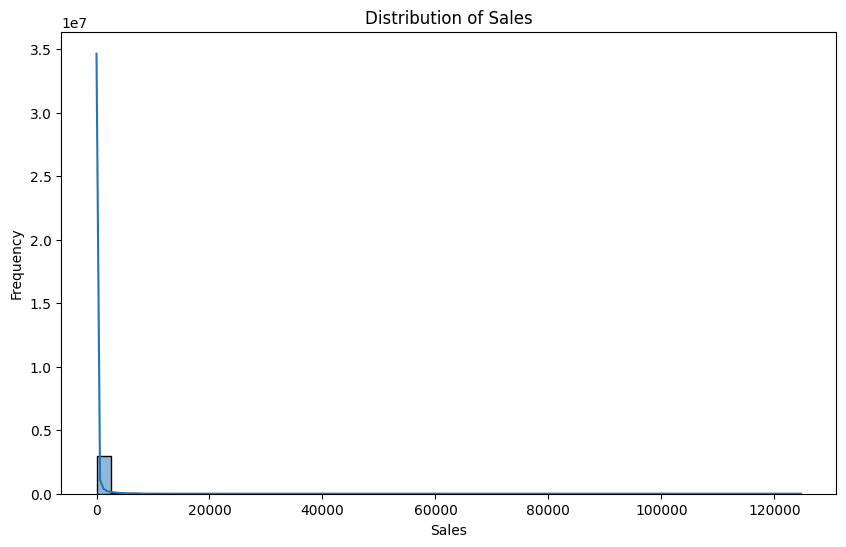

In [14]:
# Visualize the distribution of the target variable (sales)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['sales'], bins=50, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()


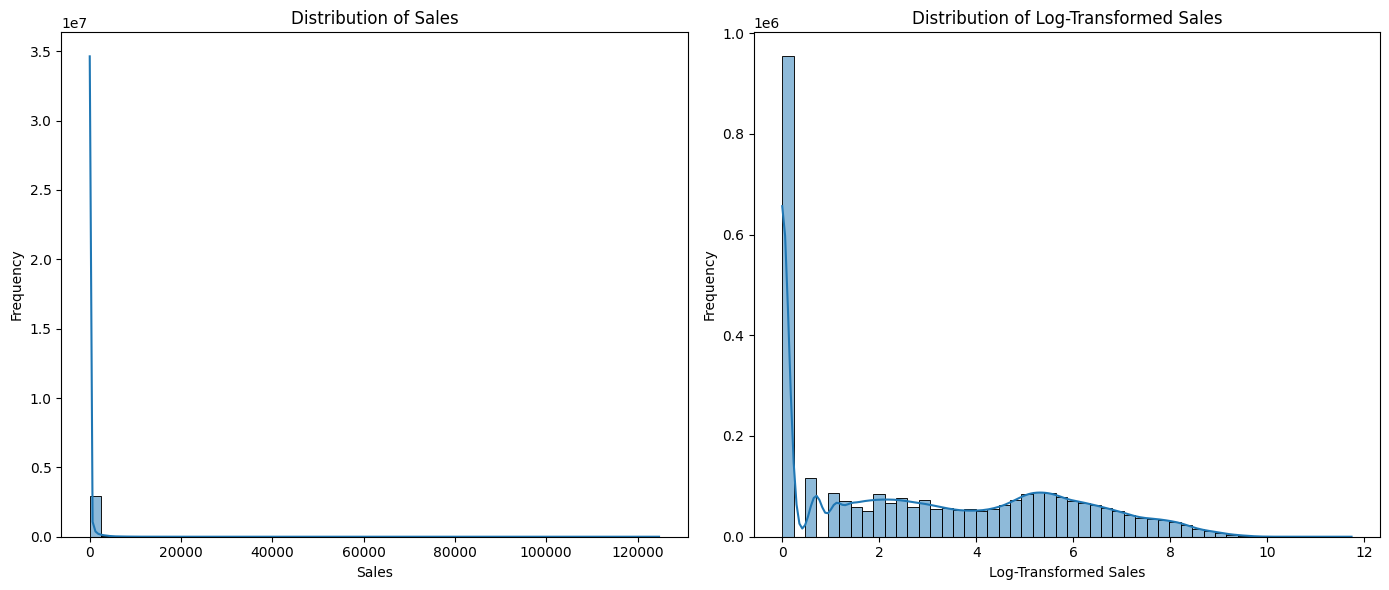

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Log transform the sales data
train_df['log_sales'] = np.log1p(train_df['sales'])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original sales distribution
sns.histplot(train_df['sales'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Sales')
axes[0].set_xlabel('Sales')
axes[0].set_ylabel('Frequency')

# Log-transformed sales distribution
sns.histplot(train_df['log_sales'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Log-Transformed Sales')
axes[1].set_xlabel('Log-Transformed Sales')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

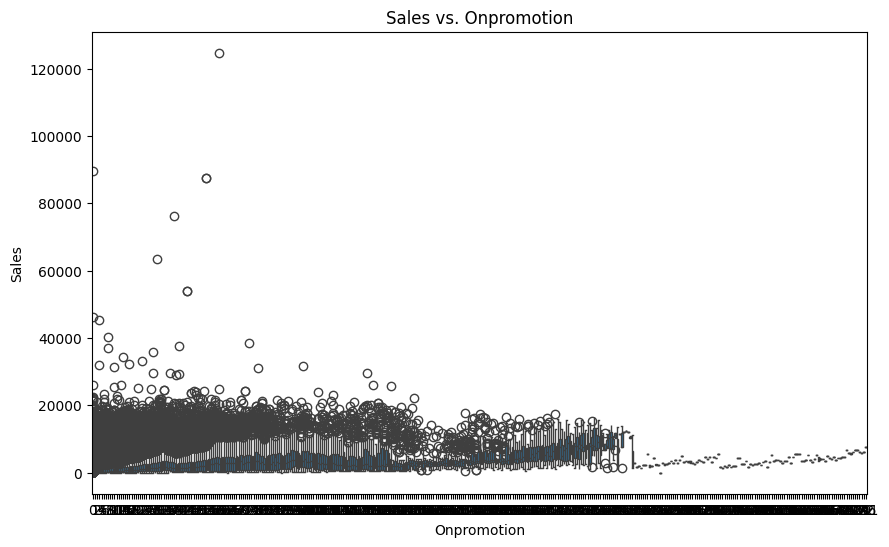

In [ ]:
# Analyze the relationships between features and the target variable
# Example: Relationship between sales and onpromotion
plt.figure(figsize=(10, 6))
sns.boxplot(x='onpromotion', y='sales', data=train_df)
plt.title('Sales vs. Onpromotion')
plt.xlabel('Onpromotion')
plt.ylabel('Sales')
plt.show()

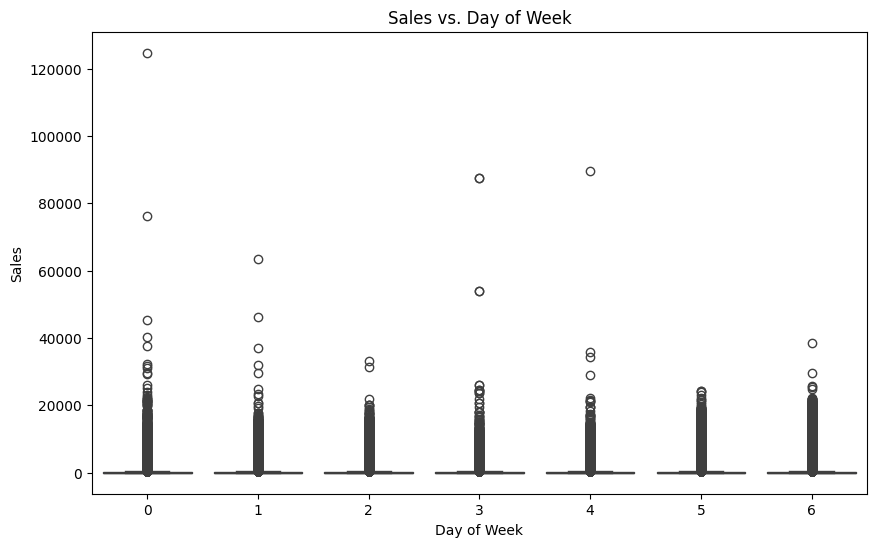

In [ ]:
# Example: Relationship between sales and day_of_week
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='sales', data=train_df)
plt.title('Sales vs. Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Sales')
plt.show()

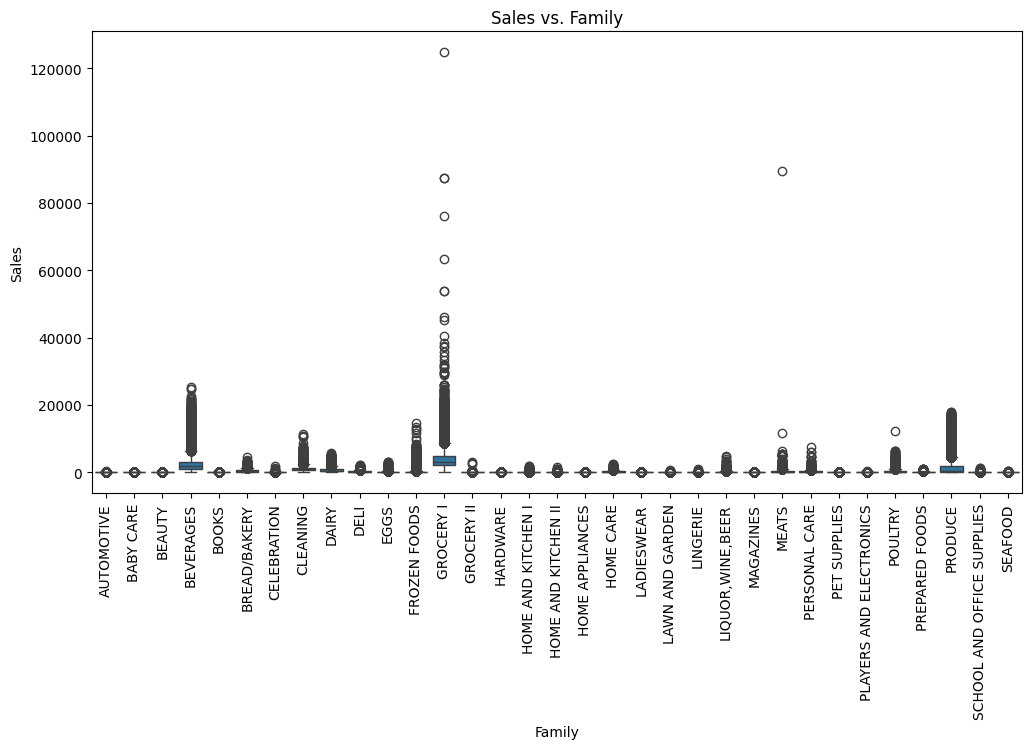

In [ ]:
# Example: Relationship between sales and family
plt.figure(figsize=(12, 6))
sns.boxplot(x='family', y='sales', data=train_df)
plt.title('Sales vs. Family')
plt.xlabel('Family')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.show()

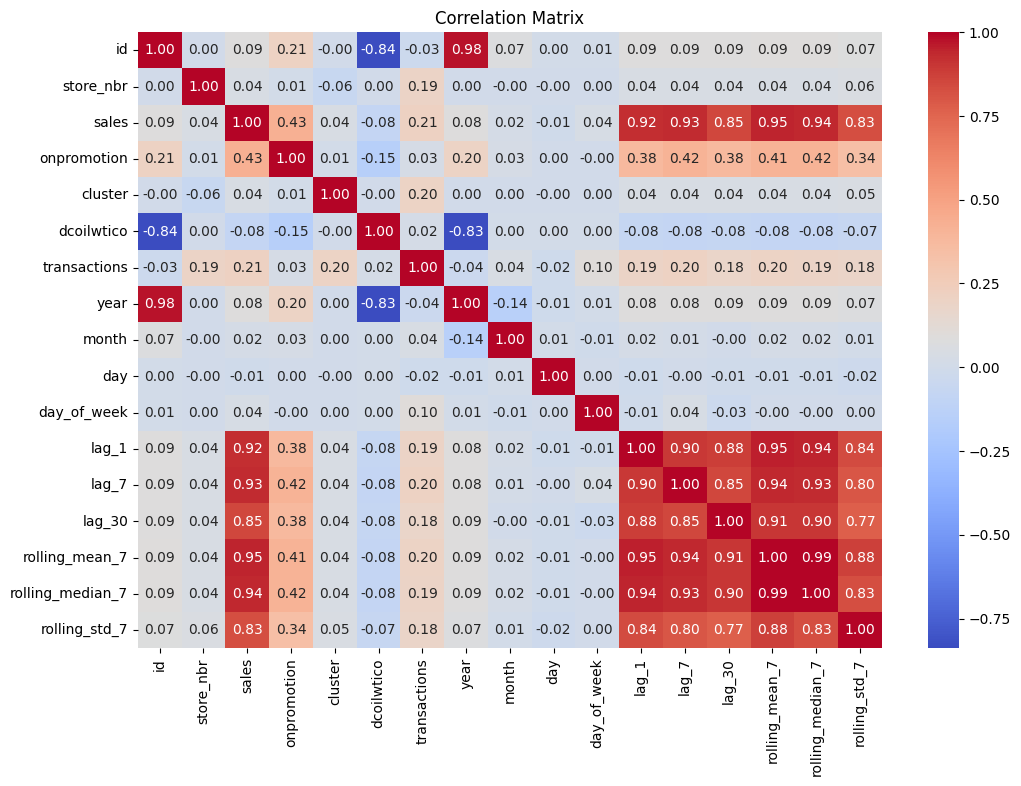

In [ ]:
# Check for correlations between numerical features
plt.figure(figsize=(12, 8))
numeric_features = train_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Model Training
Train machine learning models using scikit-learn and other libraries.

# Model Evaluation
Evaluate the trained models using appropriate metrics and validation techniques.

# Model Deployment
Prepare the model for deployment, including saving the model and creating an API for predictions.